# Installation

## Install in local Python environment (where jupyter notebook is started):

```
python -m pip install ipywidgets pandas ipyevents ipycanvas
jupyter nbextension enable --py --sys-prefix ipyevents
```

## Install in Slicer Python environment (by running the cell below):

In [ ]:
# There are no official pyzmq wheels for Python-3.6 for Windows, so we have to install manually
import os
if os.name=='nt':
    pip_install("https://files.pythonhosted.org/packages/94/e1/13059383d21444caa16306b48c8bf7a62331ca361d553d2119696ea67119/pyzmq-19.0.0-cp36-cp36m-win_amd64.whl")

pip_install("ipywidgets pandas ipyevents ipycanvas")


# Load volume, setup display
The entire view layout or selected widgets can be displayed in a notebook cell. Views can be shown using interactive widgets (slice scrolling, view rotation).
Rendering happens server-side, in Slicer, which can run on the cloud, on a container. Source data does not have to be sent to the user's computer.

IntProgress(value=0)

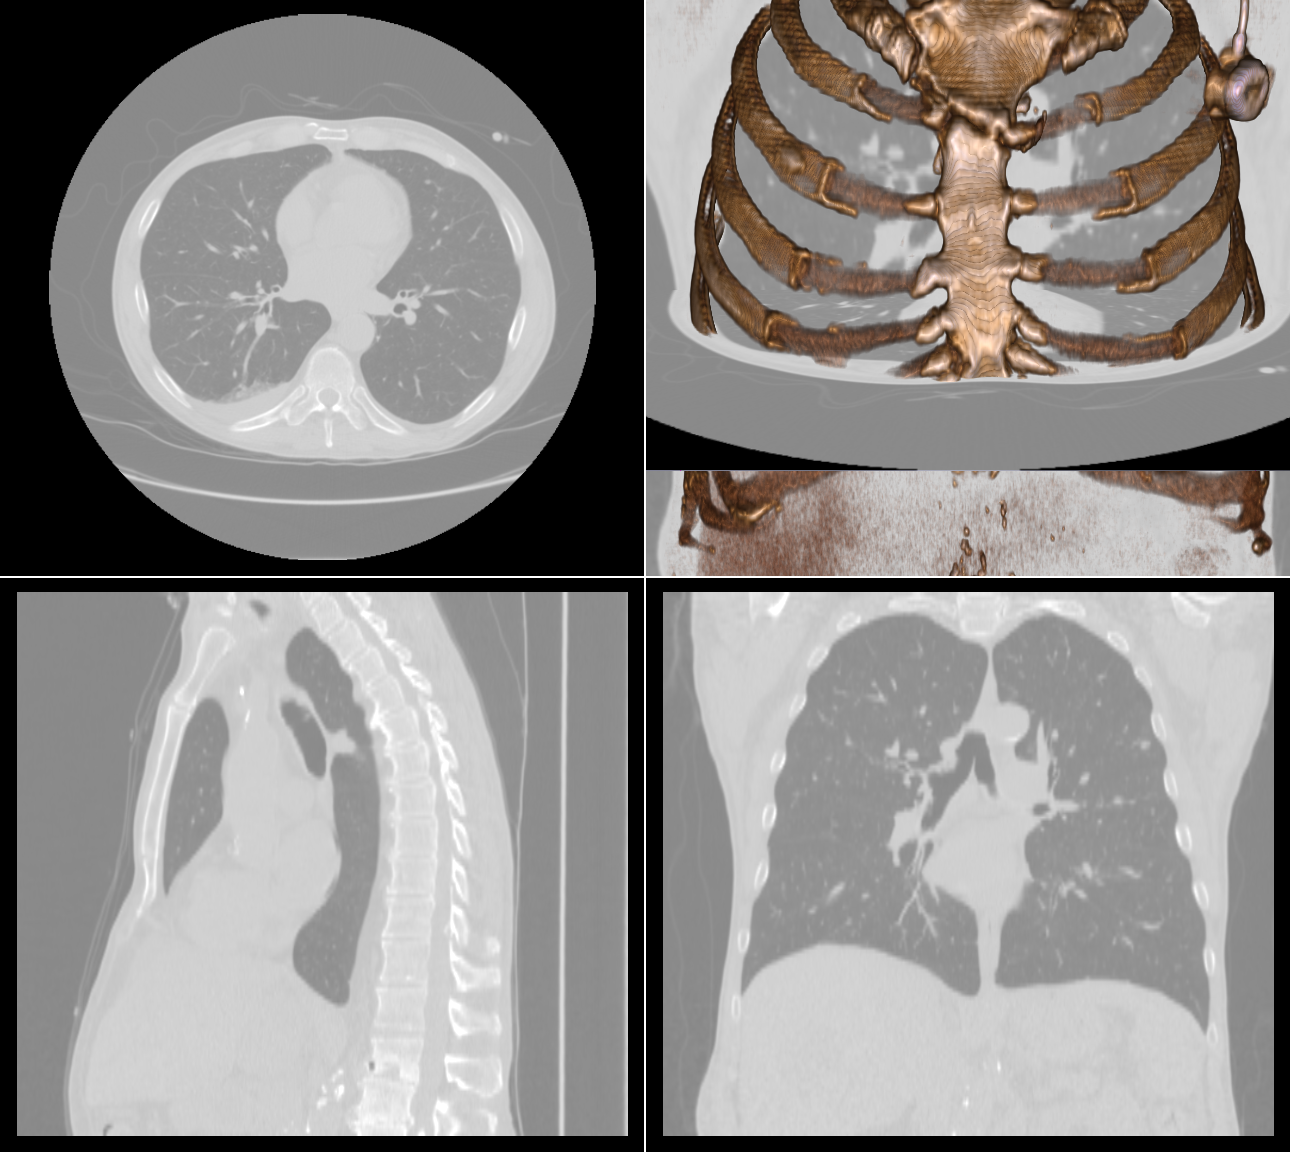

In [12]:
import JupyterNotebooksLib as slicernb

# Get a volume
slicer.mrmlScene.Clear()
volume = slicernb.downloadFromURL(
  'https://github.com/Slicer/SlicerTestingData/releases/download/SHA256/4507b664690840abb6cb9af2d919377ffc4ef75b167cb6fd0f747befdb12e38e',
  'CTChest.nrrd', "CT")[0]

# Enable 3D volume rendering
slicernb.showVolumeRendering(volume)

# Show slices in 3D view
layoutManager = slicer.app.layoutManager()
for sliceViewName in layoutManager.sliceViewNames():
    controller = layoutManager.sliceWidget(sliceViewName).sliceController()
    controller.setSliceVisible(True)

# Create markups node
interactionNode = slicer.app.applicationLogic().GetInteractionNode()
selectionNode = slicer.app.applicationLogic().GetSelectionNode()
selectionNode.SetReferenceActivePlaceNodeClassName("vtkMRMLMarkupsClosedCurveNode")
markupsNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLMarkupsClosedCurveNode")
markupsNode.GetDisplayNode().SetGlyphScale(5.0)
markupsNode.GetDisplayNode().UseGlyphScaleOn()
markupsNode.CreateDefaultDisplayNodes() 
selectionNode.SetActivePlaceNodeID(markupsNode.GetID())
    
slicernb.displayViews("FourUp")

# Annotation

In [13]:
# Interactive 3D view using mouse over image
live3d = slicernb.InteractiveViewWidget('1')
live3d.trackMouseMove = True  # process mouse move events, even if not clicking - needed for placing markups
display(live3d)

# Interactive slice view using mouse over image
liveRedSlice = slicernb.InteractiveViewWidget('R')
liveRedSlice.trackMouseMove = True
display(liveRedSlice)

from ipywidgets import interact, ToggleButton, Button

# Remove all button
def removeAll(self):
    self.markupsNode.RemoveAllControlPoints()
    for view in self.views:
        view.fullRender()

#removeAll(markupsNode, [live3d, liveRedSlice])
removeAllButton = Button(description='Remove all')
removeAllButton.removeAll = removeAll
removeAllButton.on_click(removeAllButton.removeAll)
removeAllButton.markupsNode = markupsNode
removeAllButton.views = [live3d, liveRedSlice]
display(removeAllButton) 

# Place button
@interact
def clicked(pushed=ToggleButton(description="Place points")):
    interactionNode.SetCurrentInteractionMode(interactionNode.Place if pushed else interactionNode.ViewTransform)

# Increase number of maximum Jupyter messages per second to decrease lagging of widget updates.
slicer.modules.jupyterkernel.setPollIntervalSec(0.001)

InteractiveViewWidget(height=546, width=644)

InteractiveViewWidget(height=546, width=644)

Button(description='Remove all', style=ButtonStyle())

interactive(children=(ToggleButton(value=False, description='Place points'), Output()), _dom_classes=('widget-…

In [3]:
markupsNode

,label,position.R,position.A,position.S,selected,visible,description


# Segmentation

IntProgress(value=0)

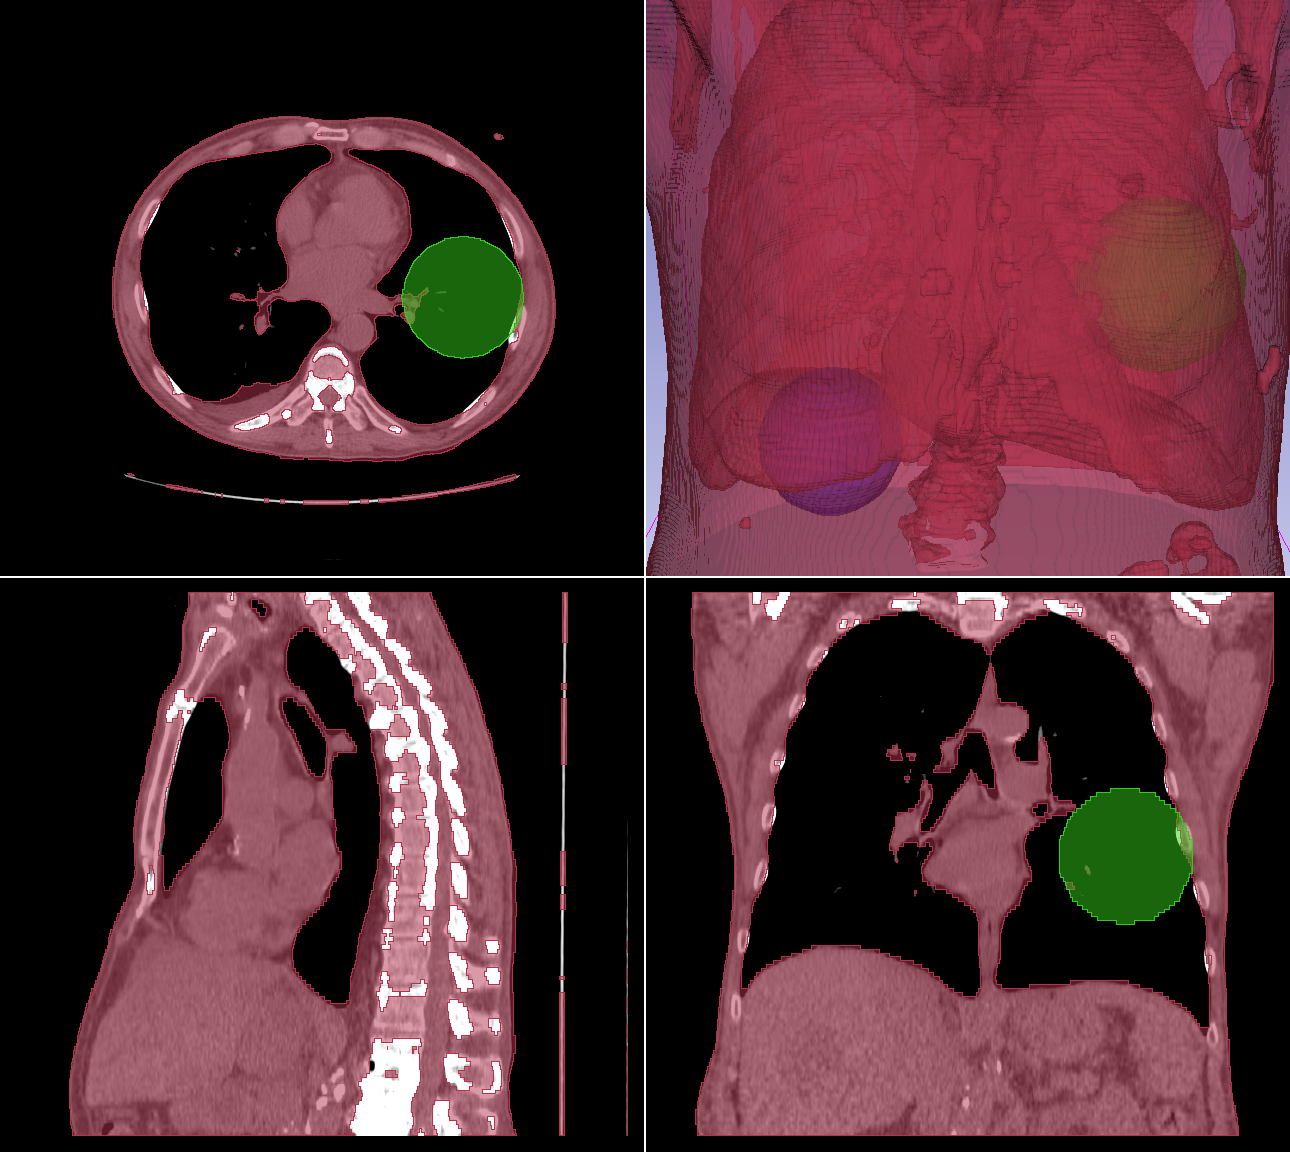

In [3]:
# Get a volume
slicer.mrmlScene.Clear()
volume = slicernb.downloadFromURL(
  'https://github.com/Slicer/SlicerTestingData/releases/download/SHA256/4507b664690840abb6cb9af2d919377ffc4ef75b167cb6fd0f747befdb12e38e',
  'CTChest.nrrd', "CT")[0]

# Create segmentation using thresholding
slicer.util.selectModule("SegmentEditor")
segmentEditorWidget = slicer.modules.segmenteditor.widgetRepresentation().self().editor
segmentEditorNode = segmentEditorWidget.mrmlSegmentEditorNode()

segmentationNode=slicer.mrmlScene.GetFirstNodeByClass("vtkMRMLSegmentationNode")
if not segmentationNode:
    segmentationNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLSegmentationNode")
segmentEditorWidget.setSegmentationNode(segmentationNode)
segmentEditorWidget.setMasterVolumeNode(volume)
segmentationNode.GetSegmentation().RemoveAllSegments()

# Add body segment
bodySegmentID = segmentationNode.GetSegmentation().AddEmptySegment("body")
segmentEditorNode.SetSelectedSegmentID(bodySegmentID)
segmentationNode.GetSegmentation().GetSegment(bodySegmentID).SetColor(0.7, 0.2, 0.3)
segmentEditorWidget.setActiveEffectByName("Threshold")
effect = segmentEditorWidget.activeEffect()
effect.setParameter("MinimumThreshold", -500)
effect.setParameter("MaximumThreshold", 220)
effect.self().onApply()

# Smoothing
segmentEditorWidget.setActiveEffectByName("Smoothing")
effect = segmentEditorWidget.activeEffect()
effect.setParameter("SmoothingMethod", "MEDIAN")
effect.setParameter("KernelSizeMm", 7)
effect.self().onApply()

# Add a sphere-shaped segment
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(-100, -30, -170)
sphereSource.SetRadius(45)
sphereSource.SetThetaResolution(20)
sphereSource.Update()
sphere1SegmentID = segmentationNode.AddSegmentFromClosedSurfaceRepresentation(sphereSource.GetOutput(), "sphere 1", [0.2,0.8,0.1])

# Add a sphere-shaped segment
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(64, 30, -230)
sphereSource.SetRadius(35)
sphereSource.SetThetaResolution(20)
sphereSource.Update()
sphere2SegmentID = segmentationNode.AddSegmentFromClosedSurfaceRepresentation(sphereSource.GetOutput(), "sphere 2", [0.2,0.1,0.8])


# Show results
segmentationNode.GetSegmentation().SetConversionParameter('Smoothing factor','0.0') # disable 3D smoothing
segmentationNode.CreateClosedSurfaceRepresentation() # show segmentation in 3D
segmentationNode.GetDisplayNode().SetOpacity3D(0.5)
volume.GetDisplayNode().AutoWindowLevelOff()
volume.GetDisplayNode().SetWindowLevel(420,30)
slicernb.displayViews("FourUp")

In [4]:
# Edit body segment using scissors
segmentEditorNode.SetSelectedSegmentID(bodySegmentID)

live3dSeg = slicernb.InteractiveViewWidget('1')
live3dSeg.trackMouseMove = True
display(live3dSeg)

# Place button
@interact
def clicked(pushed=ToggleButton(description="Scissors")):
    segmentEditorWidget.setActiveEffectByName("Scissors" if pushed else "")


InteractiveViewWidget(height=546, width=644)

interactive(children=(ToggleButton(value=False, description='Scissors'), Output()), _dom_classes=('widget-inte…

In [5]:
# Edit sphere1 segment using draw effect
segmentEditorNode.SetSelectedSegmentID(sphere1SegmentID)
segmentEditorWidget.setActiveEffectByName("Draw")

liveRedSliceSeg = slicernb.InteractiveViewWidget('R')
liveRedSliceSeg.trackMouseMove = True
liveRedSliceSeg.setQuickRenderDelay(0.5) # expect slow updates
display(liveRedSlice)

InteractiveViewWidget(height=546, width=644)

In [ ]:
# Hide the body segment so that we can see more clearly
segmentationNode.GetDisplayNode().SetSegmentVisibility(bodySegmentID, False)

# Show initial slices
before = slicernb.ThreeDViewWidget()

# Fill between slices
segmentationNode.GetDisplayNode().SetSegmentVisibility(sphere2SegmentID, False)
segmentEditorWidget.setActiveEffectByName("Fill between slices")
effect = segmentEditorWidget.activeEffect()
effect.self().onPreview()
effect.self().onApply()
segmentationNode.GetDisplayNode().SetSegmentVisibility(sphere2SegmentID, True)

# Show complete segmentation
after = slicernb.ThreeDViewWidget()

from ipywidgets import HBox
before.width="45%"
after.width="45%"
HBox([before, after])

self.extentGrowthRatio = 0.1
masterImageExtent = (0, 511, 0, 511, 0, 138)
labelsEffectiveExtent = (98, 444, 152, 348, 54, 89)
labelsExpandedExtent = [64, 478, 133, 367, 51, 92]


In [8]:
# Show all segments
segmentationNode.GetDisplayNode().SetSegmentVisibility(bodySegmentID, True)

# Enable 3D display smoothing
segmentationNode.GetSegmentation().SetConversionParameter('Smoothing factor','0.9') # enable 3D smoothing
segmentationNode.RemoveClosedSurfaceRepresentation()
segmentationNode.CreateClosedSurfaceRepresentation()

finalView = slicernb.InteractiveViewWidget("1")
finalView.trackMouseMove = False  # only re-render when mouse is dragged (not when just moved)
finalView

InteractiveViewWidget(height=546, width=644)

In [10]:
# Slice view widgets - can be arranged in layouts
from ipywidgets import HBox
display(HBox([slicernb.SliceViewWidget('Red'), slicernb.SliceViewWidget('Yellow'), slicernb.SliceViewWidget('Green')]))

# Utility/debugging functions

In [ ]:
live3d.error

In [ ]:
from ipywidgets import interact
@interact(x=(0,350,1))
def h(x=0):
    return '{0} -> {1}'.format(live3d.loggedEvents[x]['type'],live3d.loggedEvents[x])

In [ ]:
rc = InteractiveViewWidget(slicer.app.layoutManager().threeDWidget(0).threeDView())
rc.logEvents = True
rc.trackMouseMove = True
display(rc)

In [4]:
# Adjust maximum rate of Slicer's Jupyter kernel consuming Jupyter messages.
# Lower values make the notebook more responsive but too low values may make the Slicer application
# slow to respond.
slicer.modules.jupyterkernel.setPollIntervalSec(0.001)

In [ ]:
from ipywidgets import HBox
        
red=SliceViewBase('Red')
yellow=SliceViewBase('Yellow')
green=SliceViewBase('Green')
display(HBox([VBox([red.offsetSlider, red]),
              VBox([yellow.offsetSlider, yellow]), 
              VBox([green.offsetSlider, green])
             ]))